In [61]:
import math
from typing import List
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import string

warnings.filterwarnings(action='ignore', category=RuntimeWarning)

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/nshafiabadi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nshafiabadi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
def plot_surprisals(words:List[str], surprisals_df):
    num_words = len(words)
    cols = min(num_words, 3)
    rows = math.ceil(num_words / cols)

    plt.style.use('ggplot')
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axs = np.atleast_2d(axs)

    for i, word in enumerate(words):   
        word_data = surprisals_df[surprisals_df['Token'] == word].iloc[1:]  # mention this
        if word_data.empty:
            print(f'No data found for the word "{word}"')
            continue

        ax = axs[i//cols, i%cols]
        ax.plot(word_data['Steps'], word_data['MeanSurprisal'], marker='o')
        ax.set_title(f'"{word}"')
        ax.set_xlabel('BERT steps (log10)')
        ax.set_ylabel('Mean surprisal')
        ax.set_xscale('log')
        ax.invert_yaxis()

    # Remove empty subplots
    for j in range(i+1, rows*cols):
        fig.delaxes(axs.flatten()[j])

    plt.tight_layout()
    plt.show()


In [3]:
wikitext_surprisals = '../sample_data/wikitext/bert_surprisals.txt'
chang_bergen_surprisals = '../r_code/tacl_data/lm_data/bert_surprisals.txt'
bert_surprisals = pd.read_csv(wikitext_surprisals, delimiter='\t')

In [4]:
bert_surprisals = (bert_surprisals
    .sort_values(['Token', 'Steps'])
    .groupby('Token')
    .apply(lambda x: x.assign(MeanSurprisalDiff = x['MeanSurprisal'].diff().fillna(0), 
                              StdevSurprisalDiff = x['StdevSurprisal'].diff().fillna(0)))
    .reset_index(drop=True))

bert_surprisals.insert(0, 'Token', bert_surprisals.pop('Token'))
bert_surprisals

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff
0,a,0,3451,14.201838,0.386763,0.000000,512,0.000000,0.000000
1,a,20000,0,1.452711,1.769657,0.671875,512,-12.749128,1.382895
2,a,40000,0,1.050805,1.615932,0.773438,512,-0.401906,-0.153725
3,a,60000,0,0.964041,1.519993,0.789062,512,-0.086764,-0.095940
4,a,80000,0,0.926614,1.614722,0.787109,512,-0.037427,0.094729
...,...,...,...,...,...,...,...,...,...
7129,your,1600000,1,1.894058,2.084364,0.461538,13,-0.144634,0.085364
7130,your,1700000,0,1.733878,1.960023,0.615385,13,-0.160180,-0.124341
7131,your,1800000,0,1.719849,2.018352,0.692308,13,-0.014029,0.058329
7132,your,1900000,0,1.761835,2.017625,0.692308,13,0.041987,-0.000728


In [5]:
bert_surprisals['Token'].nunique()

246

In [6]:
# def plot_df(word, df):
#     word_data = df[df['Token'] == word]
#     word_data.plot(x='Steps', y='MeanSurprisal', logx=True, title=f'"{word}"').set_ylim(df['MeanSurprisal'].max(), df['MeanSurprisal'].min())


# plot_df('your', bert_surprisals)

### Most vs least frequent words

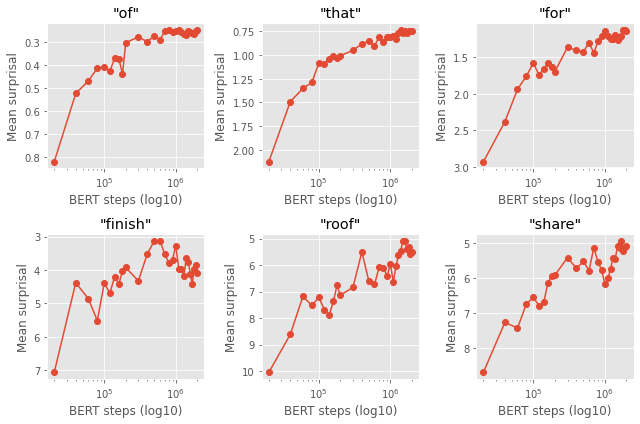

In [7]:
frequent = bert_surprisals[bert_surprisals['NumExamples'] == 512]
infrequent = bert_surprisals[bert_surprisals['NumExamples'] == 8]

plot_surprisals(
    frequent['Token'].drop_duplicates().sample(3).tolist() + infrequent['Token'].drop_duplicates().sample(3).tolist(), 
    bert_surprisals
    )

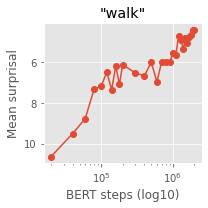

In [8]:
plot_surprisals(['walk'], bert_surprisals)

In [9]:
# import seaborn as sns
# from matplotlib import pyplot as plt

# def plot_with_sns(word, df):
#     plt.style.use('ggplot')
#     word_data = df[df['Token'] == word].iloc[1:]
#     ax = sns.pointplot(data=word_data,
#                 x='Steps',
#                 y='MeanSurprisal')
#     ax.set_xscale('log')
#     ax.invert_yaxis()

# plot_with_sns('walk', bert_surprisals)

### Corpus-level surprisals 

(6.031192538457188, 2.884962031996347)

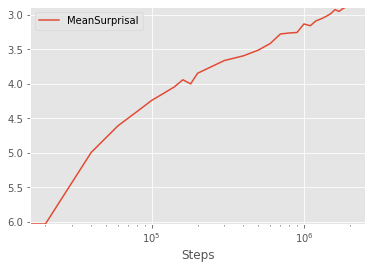

In [10]:
# for each step, average surprisal across all words

avg_surprisals = bert_surprisals.groupby('Steps')['MeanSurprisal'].mean().reset_index()
avg_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True)\
    .set_ylim(avg_surprisals['MeanSurprisal'].iloc[1:].max(), avg_surprisals['MeanSurprisal'].min())

Min surprisal: 0.7260807827115059
Max surprisal (excluding the first step): 1.8833139489094417
Average variability (excluding the first step): -0.04286048763696059


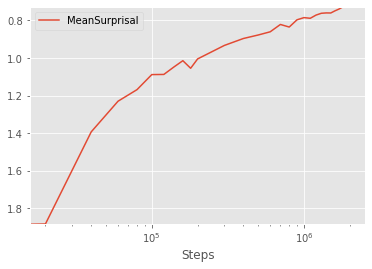

In [11]:
# for each step, average surprisal across all words with at least 512 examples (frequent words)

avg_freq_surprisals = frequent.groupby('Steps')['MeanSurprisal'].mean().reset_index().assign(Diffs=lambda x: x['MeanSurprisal'].diff().fillna(0))

avg_freq_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True)\
    .set_ylim(avg_freq_surprisals['MeanSurprisal'].iloc[1:].max(), avg_freq_surprisals['MeanSurprisal'].min())

print(f"Min surprisal: {avg_freq_surprisals['MeanSurprisal'].min()}")
print(f"Max surprisal (excluding the first step): {avg_freq_surprisals['MeanSurprisal'].iloc[1:].max()}")
print(f"Average variability (excluding the first step): {avg_freq_surprisals['Diffs'].iloc[2:].mean()}")

Min surprisal: 4.594058491966941
Max surprisal (excluding the first step): 8.177754228765314
Average variability (excluding the first step): -0.1312661263276431


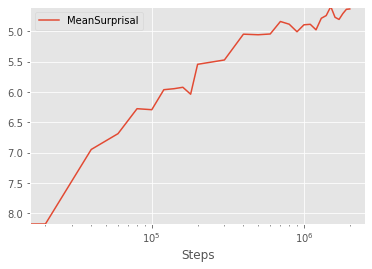

In [12]:
# for each step, average surprisal across all words with exactly 8 examples (infrequent words)

avg_infreq_surprisals = infrequent.groupby('Steps')['MeanSurprisal'].mean().reset_index().assign(Diffs=lambda x: x['MeanSurprisal'].diff().fillna(0))

avg_infreq_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True)\
    .set_ylim(avg_infreq_surprisals['MeanSurprisal'].iloc[1:].max(), avg_infreq_surprisals['MeanSurprisal'].min())

print(f"Min surprisal: {avg_infreq_surprisals['MeanSurprisal'].min()}")
print(f"Max surprisal (excluding the first step): {avg_infreq_surprisals['MeanSurprisal'].iloc[1:].max()}")
print(f"Average variability (excluding the first step): {avg_infreq_surprisals['Diffs'].iloc[2:].mean()}")

In [13]:
# plot_surprisals(bert_surprisals['Token'].drop_duplicates().tolist(), bert_surprisals)

### Words with different POS

In [14]:
def get_pos_tags(doc_path):
    with open(doc_path, 'r') as file:
        doc = file.read()
        tokens = word_tokenize(doc)     # use spacy instead 
        tokens = [token.lower() for token in tokens if token not in string.punctuation]        
        pos_tags = nltk.pos_tag(tokens)
        
        pos_dict = {}
        for token, pos in pos_tags:
            if token in pos_dict and not pos in pos_dict[token]:
                pos_dict[token].append(pos)
            else:
                pos_dict[token] = [pos]
        
    return pd.DataFrame(list(pos_dict.items()), columns=['Token', 'POS'])

In [15]:
document = "../sample_data/wikitext/wikitext103_test.txt"
pos_tags = get_pos_tags(document)
pos_tags

,Token,POS
0,robert,"[JJ, NN]"
1,boulter,[NN]
2,is,[VBZ]
3,an,[DT]
4,english,[JJ]
...,...,...
18728,fatty,[JJ]
18729,parlayed,[VBD]
18730,credibility,[NN]
18731,ronnie,[JJ]


In [16]:
merged_df = bert_surprisals.merge(pos_tags, on='Token', how='left')
merged_df

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
0,a,0,3451,14.201838,0.386763,0.000000,512,0.000000,0.000000,[DT]
1,a,20000,0,1.452711,1.769657,0.671875,512,-12.749128,1.382895,[DT]
2,a,40000,0,1.050805,1.615932,0.773438,512,-0.401906,-0.153725,[DT]
3,a,60000,0,0.964041,1.519993,0.789062,512,-0.086764,-0.095940,[DT]
4,a,80000,0,0.926614,1.614722,0.787109,512,-0.037427,0.094729,[DT]
...,...,...,...,...,...,...,...,...,...,...
7129,your,1600000,1,1.894058,2.084364,0.461538,13,-0.144634,0.085364,[PRP$]
7130,your,1700000,0,1.733878,1.960023,0.615385,13,-0.160180,-0.124341,[PRP$]
7131,your,1800000,0,1.719849,2.018352,0.692308,13,-0.014029,0.058329,[PRP$]
7132,your,1900000,0,1.761835,2.017625,0.692308,13,0.041987,-0.000728,[PRP$]


In [17]:
merged_df[merged_df['POS'].isna()]['Token'].drop_duplicates().tolist()

# Why are there words is bert_surprisals that aren't in pos_tags, when both dfs have been created from the same document?

['ant', 'bat', 'cat', 'hi']

In [18]:
merged_df = merged_df.dropna()
merged_df[merged_df['POS'].isna()]['Token'].drop_duplicates().tolist()

[]

In [19]:
all_pos_tags = [pos for pos_list in merged_df['POS'] if isinstance(pos_list, list) for pos in pos_list]
set(all_pos_tags)

{'CC',
 'DT',
 'EX',
 'IN',
 'JJ',
 'JJR',
 'MD',
 'NN',
 'NNS',
 'PRP',
 'PRP$',
 'RB',
 'RP',
 'TO',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WDT',
 'WP',
 'WRB'}

In [27]:
num_nouns = merged_df[merged_df['POS'].apply(lambda pos_list: 'NN' in pos_list)]['Token'].nunique()
num_verbs = merged_df[merged_df['POS'].apply(lambda pos_list: 'VB' in pos_list)]['Token'].nunique()
num_adjs = merged_df[merged_df['POS'].apply(lambda pos_list: 'JJ' in pos_list)]['Token'].nunique()
num_advs = merged_df[merged_df['POS'].apply(lambda pos_list: 'RB' in pos_list)]['Token'].nunique()

print(f"Total number of nouns: {num_nouns}")
print(f"Total number of verbs: {num_verbs}")
print(f"Total number of adjectives: {num_adjs}")
print(f"Total number of adverbs: {num_advs}")

Total number of nouns: 91
Total number of verbs: 38
Total number of adjectives: 37
Total number of adverbs: 11


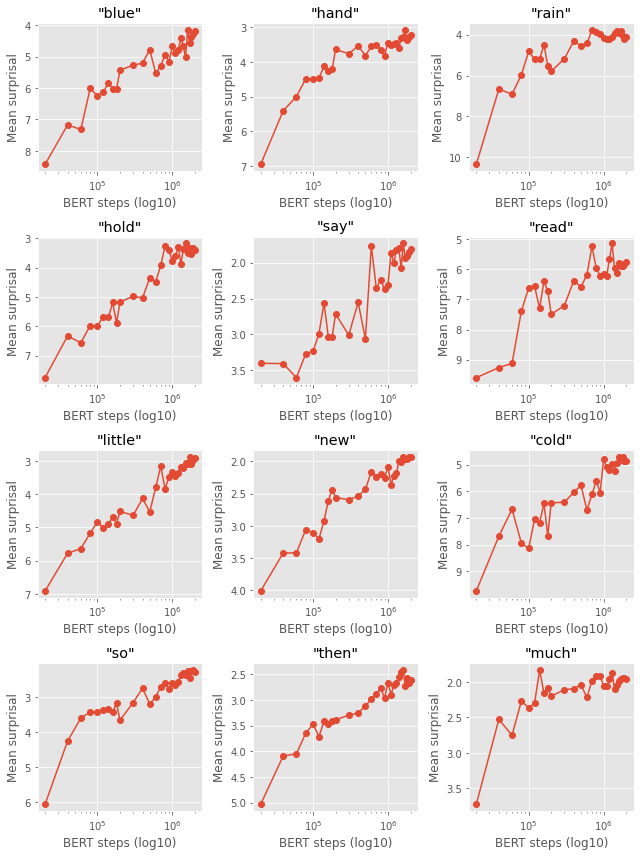

In [33]:
exclusive_NN = merged_df[merged_df['POS'].apply(lambda pos_list: 'NN' in pos_list and 'VB' not in pos_list)]
exclusive_VB = merged_df[merged_df['POS'].apply(lambda pos_list: 'VB' in pos_list and 'NN' not in pos_list)]
adj = merged_df[merged_df['POS'].apply(lambda pos_list: 'JJ' in pos_list)]
adv = merged_df[merged_df['POS'].apply(lambda pos_list: 'RB' in pos_list)]

noun_sample = exclusive_NN['Token'].drop_duplicates().sample(3).tolist()
verb_sample = exclusive_VB['Token'].drop_duplicates().sample(3).tolist()
adj_sample = adj['Token'].drop_duplicates().sample(3).tolist()
adv_sample = adv['Token'].drop_duplicates().sample(3).tolist()

plot_surprisals(
    noun_sample + verb_sample + adj_sample + adv_sample, 
    merged_df
    )

(7.415364624541483, 3.60816396754465)

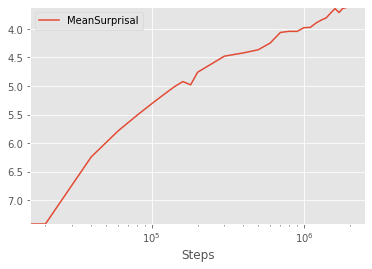

In [29]:
# for each step, average surprisal across all words with 'NN' tag (Noun, singular or mass)

NN_avg_surprisals = exclusive_NN.groupby('Steps')['MeanSurprisal'].mean().reset_index()
NN_avg_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True)\
    .set_ylim(NN_avg_surprisals['MeanSurprisal'].iloc[1:].max(), NN_avg_surprisals['MeanSurprisal'].min())

(6.215640715190342, 2.880931196468217)

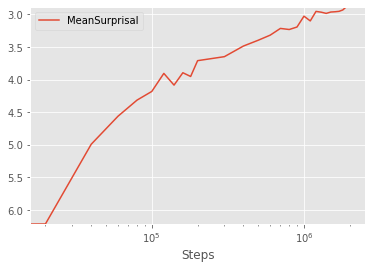

In [30]:
# for each step, average surprisal across all words with 'VB' tag (Verb, base form)

VB_avg_surprisals = exclusive_VB.groupby('Steps')['MeanSurprisal'].mean().reset_index()
VB_avg_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True)\
    .set_ylim(VB_avg_surprisals['MeanSurprisal'].iloc[1:].max(), VB_avg_surprisals['MeanSurprisal'].min())

(6.991540812157296, 3.6383312425097905)

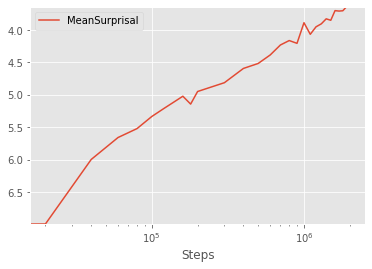

In [31]:
# for each step, average surprisal across all words with 'JJ' tag (Adjective)

adj_avg_surprisals = adj.groupby('Steps')['MeanSurprisal'].mean().reset_index()
adj_avg_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True)\
    .set_ylim(adj_avg_surprisals['MeanSurprisal'].iloc[1:].max(), adj_avg_surprisals['MeanSurprisal'].min())

(4.91528185931119, 2.367242244156924)

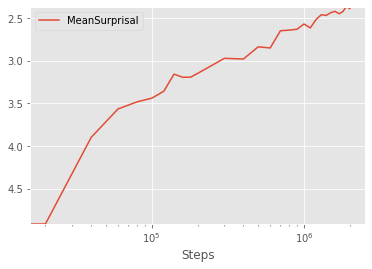

In [32]:
# for each step, average surprisal across all words with 'RB' tag (Adverb)

adv_avg_surprisals = adv.groupby('Steps')['MeanSurprisal'].mean().reset_index()
adv_avg_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True)\
    .set_ylim(adv_avg_surprisals['MeanSurprisal'].iloc[1:].max(), adv_avg_surprisals['MeanSurprisal'].min())

### Top 5 largest and smallest absolute diffs

In [170]:
largest_abs_diffs = merged_df.loc[merged_df['MeanSurprisalDiff'].abs().nlargest(5).index]
largest_abs_diffs

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
6004,the,20000,0,0.781342,1.324811,0.886719,512,-15.236831,0.945859,[DT]
6613,was,20000,0,1.192383,1.659401,0.789062,512,-14.026222,1.327233,[VBD]
3481,is,20000,0,1.775125,2.488918,0.690141,426,-13.900096,2.059086,[VBZ]
610,be,20000,0,0.894825,1.832280,0.876133,331,-13.769206,1.415900,[VB]
1799,did,20000,0,1.840310,2.702644,0.710526,114,-13.755656,2.364045,[VBD]


In [171]:
smallest_abs_diffs = merged_df[merged_df['Steps'] != 0].sort_values(by='MeanSurprisalDiff', key=abs).head(5)
smallest_abs_diffs

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
213,animal,200000,19,9.230306,7.028107,0.300000,10,0.000034,-0.208739,[JJ]
6986,wind,1800000,0,2.874189,3.955638,0.593750,32,0.000041,-0.073518,[NN]
6379,to,2000000,0,0.370319,1.141598,0.927734,512,-0.000128,-0.021952,[TO]
6204,they,1900000,0,0.971847,1.899306,0.806867,233,0.000158,0.056457,[PRP]
6012,the,180000,0,0.537781,1.193020,0.896484,512,-0.000206,0.006834,[DT]


In [137]:
# for each time step, look for the n largest and n smallest

In [172]:
largest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nlargest(5, 'MeanSurprisalDiff'))
largest_diffs[largest_diffs['Steps'] != 0]

Token    Steps  MedianRank  MeanSurprisal  StdevSurprisal  \
Steps                                                                       
20000   4989     pool    20000         673      13.602396        4.587351   
        4902    plate    20000         155      11.773693        3.391031   
        204    animal    20000         272      13.034536        5.573676   
        3887     mine    20000         444      11.081578        4.587145   
        5801     stop    20000          33      10.366323        3.669285   
...               ...      ...         ...            ...             ...   
2000000 5741    stand  2000000           1       4.904797        5.318739   
        2290   finish  2000000           0       4.089416        4.957127   
        1652  country  2000000           1       4.020650        4.083418   
        5799    stone  2000000           1       3.589800        3.777956   
        4523     open  2000000           3       5.119033        3.745814   

              Accuracy  NumExamples  MeanSurprisalDiff  StdevSurprisalDiff  \
Steps                                                                        
20000   4989  0.000000           13          -1.966759            4.265606   
        4902  0.000000            9          -3.018153            2.993187   
        204   0.000000           10          -3.578323            5.168723   
        3887  0.000000           12          -3.771296            4.151762   
        5801  0.000000           11          -4.251307            3.233260   
...                ...          ...                ...                 ...   
2000000 5741  0.375000            8           0.244696            0.450888   
        2290  0.500000            8           0.235639            0.519237   
        1652  0.297872           47           0.216776            0.064428   
        5799  0.400000           35           0.177921            0.122260   
        4523  0.185185           27           0.152835            0.018718   

                   POS  
Steps                   
20000   4989      [NN]  
        4902      [NN]  
        204       [JJ]  
        3887      [NN]  
        5801  [VB, NN]  
...                ...  
2000000 5741      [VB]  
        2290  [VB, NN]  
        1652      [NN]  
        5799      [NN]  
        4523      [JJ]  

[140 rows x 10 columns]

In [173]:
smallest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nsmallest(5, 'MeanSurprisalDiff'))
smallest_diffs[smallest_diffs['Steps'] != 0]

Token    Steps  MedianRank  MeanSurprisal  StdevSurprisal  \
Steps                                                                     
20000   6004    the    20000           0       0.781342        1.324811   
        6613    was    20000           0       1.192383        1.659401   
        3481     is    20000           0       1.775125        2.488918   
        610      be    20000           0       0.894825        1.832280   
        1799    did    20000           0       1.840310        2.702644   
...             ...      ...         ...            ...             ...   
2000000 1710    cup  2000000           0       1.811673        2.518537   
        3276  horse  2000000           3       5.777861        4.964182   
        2261   fine  2000000           0       5.577559        5.396832   
        2609    gas  2000000           0       2.693766        2.952634   
        3624  light  2000000           1       3.569161        3.689013   

              Accuracy  NumExamples  MeanSurprisalDiff  StdevSurprisalDiff  \
Steps                                                                        
20000   6004  0.886719          512         -15.236831            0.945859   
        6613  0.789062          512         -14.026222            1.327233   
        3481  0.690141          426         -13.900096            2.059086   
        610   0.876133          331         -13.769206            1.415900   
        1799  0.710526          114         -13.755656            2.364045   
...                ...          ...                ...                 ...   
2000000 1710  0.600000           10          -0.246657           -0.338083   
        3276  0.300000           10          -0.238966           -0.010078   
        2261  0.500000            8          -0.156815           -0.113910   
        2609  0.545455           11          -0.147742           -0.104999   
        3624  0.469388           49          -0.142424           -0.004846   

                   POS  
Steps                   
20000   6004      [DT]  
        6613     [VBD]  
        3481     [VBZ]  
        610       [VB]  
        1799     [VBD]  
...                ...  
2000000 1710      [NN]  
        3276      [NN]  
        2261  [JJ, VB]  
        2609      [NN]  
        3624      [NN]  

[140 rows x 10 columns]

In [178]:
largest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nlargest(1).index])
largest_abs_diffs[largest_abs_diffs['Steps'] != 0]

,,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
Steps,,,,,,,,,,,
20000,6004,the,20000,0,0.781342,1.324811,0.886719,512,-15.236831,0.945859,[DT]
40000,5135,rain,40000,14,6.660968,2.497090,0.000000,12,-3.680320,-0.167746,[NN]
60000,2555,garden,60000,1,3.871726,2.658861,0.416667,12,-2.786212,-0.542675,[NN]
80000,5166,read,80000,15,7.387403,4.770860,0.111111,9,-1.735988,-0.352928,[VB]
100000,4906,plate,100000,14,9.338552,5.401127,0.000000,9,-2.467635,0.903203,[NN]
120000,5719,stand,120000,1,5.174742,4.727767,0.375000,8,-1.407358,-1.213320,[VB]
140000,5546,sister,140000,4,4.782732,3.715522,0.250000,16,-1.896325,-1.111567,[NN]
160000,6852,white,160000,10,8.491396,6.871418,0.200000,20,1.496663,1.705338,[JJ]
180000,1459,chin,180000,33,8.215579,2.598957,0.000000,8,1.821589,0.132145,"[JJ, NN]"


In [177]:
smallest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nsmallest(1).index])
smallest_abs_diffs[smallest_abs_diffs['Steps'] != 0]

,,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
Steps,,,,,,,,,,,
20000,4989,pool,20000,673,13.602396,4.587351,0.000000,13,-1.966759,4.265606,[NN]
40000,5367,say,40000,0,3.406016,3.461776,0.500000,8,0.004816,1.087647,[VB]
60000,4179,new,60000,1,3.420374,3.427483,0.492147,191,-0.002098,0.059564,[JJ]
80000,1831,do,80000,0,2.598981,3.054857,0.640625,64,-0.000379,0.329602,[VB]
100000,6675,we,100000,0,2.188920,2.509898,0.606061,33,-0.000466,0.181110,[PRP]
120000,6328,time,120000,0,2.101686,3.355426,0.709957,231,0.002428,0.134265,[NN]
140000,5343,same,140000,0,2.066099,2.961968,0.698795,83,-0.001190,0.129520,[JJ]
160000,6968,wind,160000,1,4.526876,5.213159,0.468750,32,-0.000319,0.544056,[NN]
180000,6012,the,180000,0,0.537781,1.193020,0.896484,512,-0.000206,0.006834,[DT]


### Pipeline for retrieving the identity of a masked token in a sentence

In [55]:
import logging
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM

# suppress warnings
logging.getLogger("transformers").setLevel(logging.ERROR)


def unmask(sentence, checkpoint):
    """
    - INPUT: a sentence with a masked token w
    - OUTPUT: identity of the masked token w, prediction probability and surprisal 
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = AutoModelForMaskedLM.from_pretrained(checkpoint).to(device)

    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)

    inputs = tokenizer(sentence.strip(), return_tensors='pt').to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits
    
    probs = F.softmax(logits, dim=-1)

    # getting the top predicted token and its probability at the masked position
    mask_token_index = torch.where(inputs['input_ids'][0] == tokenizer.mask_token_id)[0]
    top_token_prob, top_token = torch.max(probs[0, mask_token_index, :], dim=-1)
    predicted_token = tokenizer.convert_ids_to_tokens(top_token.item())
    
    surprisal = -torch.log2(top_token_prob).item()

    return predicted_token, top_token_prob.item(), surprisal

In [67]:
def get_prediction_data(sentence, model):
    prediction_data = {'step': [], 'prediction': [], 'probability': [], 'surprisal': []}
    steps = list(range(0, 200_000, 20_000)) + list(range(200_000, 2_100_000, 100_000))
    for step in steps:
        checkpoint = model + f'-step_{step//1000}k'

        unmasked_token, probability, surprisal = unmask(sentence, checkpoint)

        prediction_data['step'].append(step)
        prediction_data['prediction'].append(unmasked_token)
        prediction_data['probability'].append(probability)
        prediction_data['surprisal'].append(surprisal)

    return pd.DataFrame(prediction_data)

In [68]:
sentence = 'The dogs [MASK].'
model = 'google/multiberts-seed_0'

df_1 = get_prediction_data(sentence, model)
df_1

,step,prediction,probability,surprisal
0,0,44,0.000197,12.309873
1,20000,used,0.021952,5.509478
2,40000,dogs,0.031794,4.975119
3,60000,laugh,0.022311,5.486074
4,80000,roared,0.062831,3.992390
5,100000,died,0.033060,4.918781
6,120000,died,0.060889,4.037679
7,140000,laughed,0.052121,4.261981
8,160000,died,0.040193,4.636928
9,180000,died,0.084498,3.564945


<AxesSubplot:xlabel='step'>

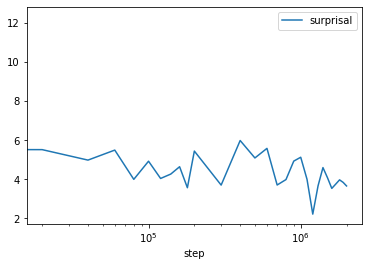

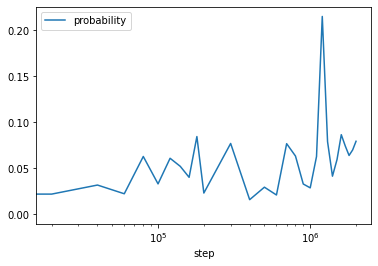

In [69]:
df_1.plot(x='step', y='surprisal', logx=True)
df_1.plot(x='step', y='probability', logx=True)

In [62]:
sentence = 'The dogs in the park [MASK].'
model = 'google/multiberts-seed_0'

df_2 = get_prediction_data(sentence, model)
df_2

,step,prediction,probability,surprisal
0,0,ham,0.000237,12.044330
1,20000,park,0.089234,3.486258
2,40000,disappeared,0.032525,4.942299
3,60000,survived,0.021062,5.569197
4,80000,cheered,0.044598,4.486887
5,100000,died,0.032322,4.951353
6,120000,won,0.047199,4.405097
7,140000,are,0.042923,4.542093
8,160000,survive,0.051388,4.282414
9,180000,survive,0.112268,3.154975


<AxesSubplot:xlabel='step'>

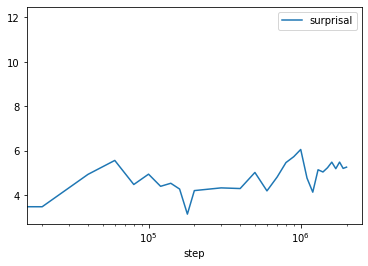

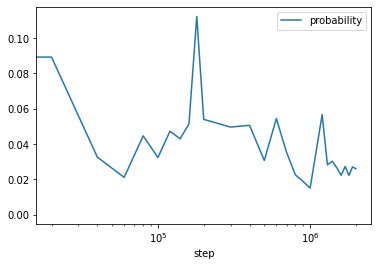

In [66]:
df_2.plot(x='step', y='surprisal', logx=True)
df_2.plot(x='step', y='probability', logx=True)